d: 0.495
max_angle: -0.34073979726153913


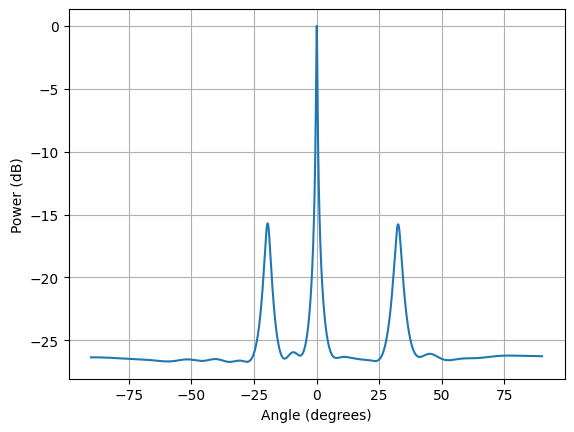

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# Array params
center_freq = 3.3e9
sample_rate = 30e6
d = 0.045 * center_freq / 3e8
print("d:", d)

# Includes all three signals, we'll call C our SOI
filename = '3p3G_A_B_C.npy'
X = np.load(filename)
Nr = X.shape[0]

# Perform DOA to find angle of arrival of C
theta_scan = np.linspace(-1*np.pi/2, np.pi/2, 10000) # between -90 and +90 degrees
results = []
R = X @ X.conj().T # Calc covariance matrix. gives a Nr x Nr covariance matrix of the samples
Rinv = np.linalg.pinv(R) # pseudo-inverse tends to work better than a true inverse
for theta_i in theta_scan:
   a = np.exp(-2j * np.pi * d * np.arange(X.shape[0]) * np.sin(theta_i)) # steering vector in the desired direction theta_i
   a = a.reshape(-1,1) # make into a column vector
   power = 1/(a.conj().T @ Rinv @ a).squeeze() # MVDR power equation
   power_dB = 10*np.log10(np.abs(power)) # power in signal, in dB so its easier to see small and large lobes at the same time
   results.append(power_dB)
results -= np.max(results) # normalize to 0 dB at peak

# Pull out angle of C, after zeroing out the angles that include the interferers
results_temp = np.array(results)
results_temp[int(len(results)*0.4):] = -9999*np.ones(int(len(results)*0.6))
max_angle = theta_scan[np.argmax(results_temp)] # radians
print("max_angle:", max_angle)

# DOA results
plt.plot(theta_scan * 180/np.pi, results)
plt.xlabel('Angle (degrees)')
plt.ylabel('Power (dB)')
plt.grid()
plt.show()

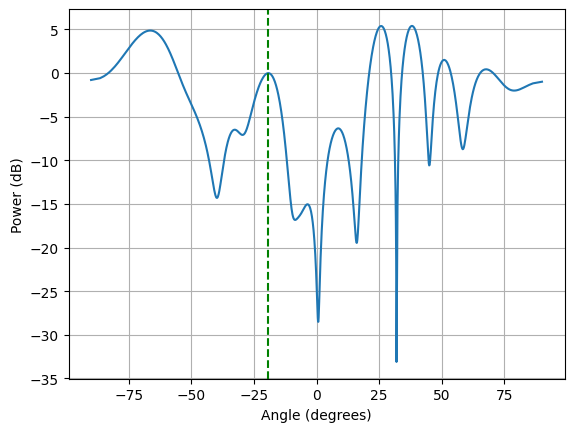

In [8]:
# MVDR weights towards C
s = np.exp(-2j * np.pi * d * np.arange(Nr) * np.sin(max_angle)) # steering vector in the desired direction theta
s = s.reshape(-1,1) # make into a column vector (size 3x1)
w = (Rinv @ s)/(s.conj().T @ Rinv @ s) # MVDR/Capon equation

# Visualize the beam pattern if we point towards C
N_fft = 1024
w = w.squeeze() # remove the extra dimension (size 3x1 -> size 3)
w = np.conj(w) # or else our answer will be negative/inverted
w_padded = np.concatenate((w, np.zeros(N_fft - Nr))) # zero pad to N_fft elements to get more resolution in the FFT
w_fft_dB = 10*np.log10(np.abs(np.fft.fftshift(np.fft.fft(w_padded)))**2) # magnitude of fft in dB
theta_bins = np.arcsin(np.linspace(-1, 1, N_fft)) # Map the FFT bins to angles in radians)
plt.plot(np.rad2deg(theta_bins), w_fft_dB) # MAKE SURE TO USE RADIAN FOR POLAR
plt.axvline(x=np.rad2deg(max_angle), color='green', linestyle='--', label='max angle')
plt.grid()
plt.xlabel('Angle (degrees)')
plt.ylabel('Power (dB)')
plt.show()


Now, using training data, which we emulate using a recording that doesnt have C in it, before doing DOA on the actual one with all 3

d: 0.495


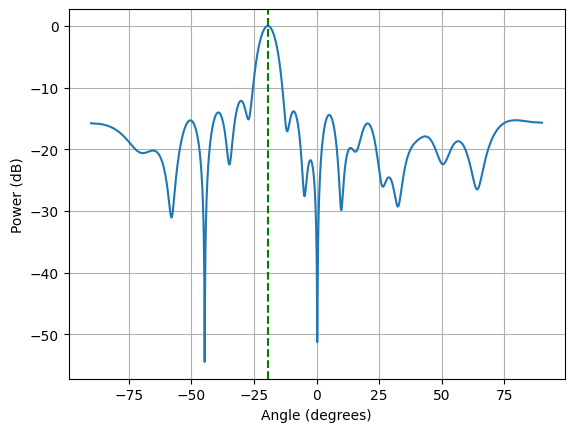

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# Array params
center_freq = 3.3e9
sample_rate = 30e6
d = 0.045 * center_freq / 3e8
print("d:", d)

# Load "training data" which is just A and B, then calc Rinv
filename = '3p3G_A_B.npy'
X_A_B = np.load(filename)
R_training = X_A_B @ X_A_B.conj().T # Calc covariance matrix
Rinv_training = np.linalg.pinv(R_training)

# Includes all three signals, we'll call C our SOI
filename = '3p3G_A_B_C.npy'
X = np.load(filename)
Nr = X.shape[0]

max_angle = -0.34073979726153913 # found in step 1, this is the DOA of C in radians

# Calc MVDR weights using training Rinv
s = np.exp(-2j * np.pi * d * np.arange(Nr) * np.sin(max_angle)) # steering vector in the desired direction theta
s = s.reshape(-1,1) # make into a column vector (size 3x1)
w = (Rinv_training @ s)/(s.conj().T @ Rinv_training @ s) # MVDR/Capon equation

# Visualize the beam pattern if we point towards C
N_fft = 1024
w = w.squeeze() # remove the extra dimension (size 3x1 -> size 3)
w = np.conj(w) # or else our answer will be negative/inverted
w_padded = np.concatenate((w, np.zeros(N_fft - Nr))) # zero pad to N_fft elements to get more resolution in the FFT
w_fft_dB = 10*np.log10(np.abs(np.fft.fftshift(np.fft.fft(w_padded)))**2) # magnitude of fft in dB
theta_bins = np.arcsin(np.linspace(-1, 1, N_fft)) # Map the FFT bins to angles in radians)
plt.plot(np.rad2deg(theta_bins), w_fft_dB) # MAKE SURE TO USE RADIAN FOR POLAR
plt.axvline(x=np.rad2deg(max_angle), color='green', linestyle='--', label='max angle')
plt.grid()
plt.xlabel('Angle (degrees)')
plt.ylabel('Power (dB)')
plt.show()